Notebook to attempt to predict state covid cases per 100K based on state by state macro information. 

In [45]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.stats import sem
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Get state by state cases per day 
df = pd.read_csv('./data/nga_subnational_covid19_hera.csv')

In [3]:
df.head()

,ID,DATE,ISO_3,PAYS,ID_PAYS,REGION,ID_REGION,CONTAMINES,DECES,GUERIS,CONTAMINES_FEMME,CONTAMINES_HOMME,CONTAMINES_GENRE_NON_SPECIFIE,SOURCE
0,1,27/02/2020,NGA,Nigéria,15,Abia,170,0.0,0.0,0.0,0.0,0.0,0.0,Nigeria Centre for Disease Control
1,2,27/02/2020,NGA,Nigéria,15,Adamawa,171,0.0,0.0,0.0,0.0,0.0,0.0,Nigeria Centre for Disease Control
2,3,27/02/2020,NGA,Nigéria,15,Akwa Ibom,172,0.0,0.0,0.0,0.0,0.0,0.0,Nigeria Centre for Disease Control
3,4,27/02/2020,NGA,Nigéria,15,Anambra,173,0.0,0.0,0.0,0.0,0.0,0.0,Nigeria Centre for Disease Control
4,5,27/02/2020,NGA,Nigéria,15,Bauchi,174,0.0,0.0,0.0,0.0,0.0,0.0,Nigeria Centre for Disease Control


We want to calculate the total number of cases by state. 

In [4]:
data = df.groupby('REGION')['CONTAMINES'].sum().reset_index()

In [5]:
data.head()

,REGION,CONTAMINES
0,Abia,1134.0
1,Adamawa,573.0
2,Akwa Ibom,698.0
3,Anambra,515.0
4,Bauchi,1107.0


In [6]:
data['Total Cases'] = data['CONTAMINES'].astype('int')
data.drop('CONTAMINES', inplace=True, axis=1)
data.head()

,REGION,Total Cases
0,Abia,1134
1,Adamawa,573
2,Akwa Ibom,698
3,Anambra,515
4,Bauchi,1107


Rather than cases we want to look at a metric such as cases per million people, to adjust for state populations.

In [7]:
pop_data = pd.read_csv('data/nga_pop_adm1_2016.csv').sort_values('admin1Name_en')
pop_data.head()

,admin1Name_en,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Abia,NG001,Nigeria,NG,3644714
36,Adamawa,NG002,Nigeria,NG,4145684
3,Akwa Ibom,NG003,Nigeria,NG,5353609
15,Anambra,NG004,Nigeria,NG,5425334
23,Bauchi,NG005,Nigeria,NG,6386388


In [8]:
data = data.set_index('REGION').join(pop_data.set_index('admin1Name_en'))
data = data[['Total Cases', 'Unnamed: 4']]
data.rename(columns={'Unnamed: 4': 'Population'}, inplace=True)

In [9]:
data.head()

,Total Cases,Population
REGION,,
Abia,1134,3644714.0
Adamawa,573,4145684.0
Akwa Ibom,698,5353609.0
Anambra,515,5425334.0
Bauchi,1107,6386388.0


In [10]:
data.dropna(inplace =True)

In [11]:
data['Population'] = data['Population'].astype('int')

In [12]:
data.head()

,Total Cases,Population
REGION,,
Abia,1134,3644714
Adamawa,573,4145684
Akwa Ibom,698,5353609
Anambra,515,5425334
Bauchi,1107,6386388


In [13]:
data['Cases/100,000'] = 100000 * data['Total Cases'] / data['Population']

In [115]:
data.head()

,Total Cases,Population,"Cases/100,000"
REGION,,,
Abia,1134,3644714,31.113552
Adamawa,573,4145684,13.821603
Akwa Ibom,698,5353609,13.037934
Anambra,515,5425334,9.492503
Bauchi,1107,6386388,17.333742


Now we've got a target variable - Cases/100,000 we can introduce some features to try and estimate it. We load data about each state from the Open Data for Africa project https://nigeria.opendataforafrica.org

In [15]:
open_data = pd.read_csv('./data/Nigeria Open Data.csv')

In [16]:
open_data.head()

,State,Infant Mortality,Fertility rate,Improved drinking water,Percentge heard of AIDS,Literacy rate,Area
0,Abia,62.40,6.53,87.85,99.75,94.24,6320
1,Federal Capital Territory,59.07,3.88,65.54,98.72,78.84,7315
2,Adamawa,36.38,3.28,37.68,85.15,55.82,36917
3,Akwa Ibom,59.07,3.88,65.54,98.72,78.84,7081
4,Anambra,28.13,5.34,74.89,98.71,92.11,4844


In [17]:
data = data.join(open_data.set_index('State'))

In [18]:
data.head()

,Total Cases,Population,"Cases/100,000",Infant Mortality,Fertility rate,Improved drinking water,Percentge heard of AIDS,Literacy rate,Area
REGION,,,,,,,,,
Abia,1134,3644714,31.113552,62.40,6.53,87.85,99.75,94.24,6320
Adamawa,573,4145684,13.821603,36.38,3.28,37.68,85.15,55.82,36917
Akwa Ibom,698,5353609,13.037934,59.07,3.88,65.54,98.72,78.84,7081
Anambra,515,5425334,9.492503,28.13,5.34,74.89,98.71,92.11,4844
Bauchi,1107,6386388,17.333742,85.62,4.05,35.02,88.83,19.26,49119


In [19]:
# Fill in nans 
data = data.apply(lambda x: x.fillna(x.mean()),axis=0)

In [20]:
data['Pop Density'] = data['Population'] / data ['Area']

Now we have some data we can look at training a model unfortunately there's not a lot of data here but we can attempt to draw some conclusions. 

<AxesSubplot:>

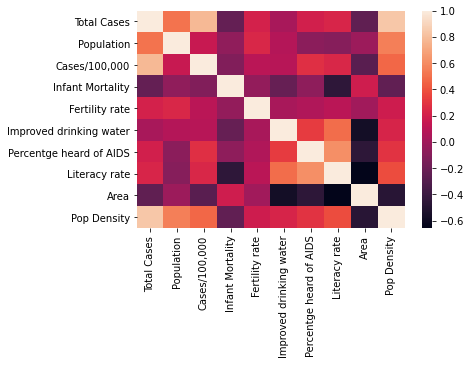

In [21]:
sns.heatmap(data.corr())

We can see some correlations there, both with the target variable and between the features, so we may want to try dropping some of the correlated features.

In [24]:
X = data[['Infant Mortality','Fertility rate','Improved drinking water','Percentge heard of AIDS','Literacy rate','Pop Density']]
y = data['Cases/100,000']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We'll try and fit three models to the data
 * Linear Regression
 * Decision Tree
 * Ensemble Method

The first 2 are useful as we can analyse which features contribute to the model. While the Ensemble method should have a better score it will not be as interpretable.

In [33]:
linearModel = LinearRegression().fit(X_train, y_train)

lin_preds = linearModel.predict(X_test)

lin_mse = mean_squared_error(y_test, lin_preds)
lin_rmse = np.sqrt(lin_mse)
print(f'Linear regression RMSE {lin_rmse:.2f}')

Linear regression RMSE 164.65


In [34]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)

tree_mse = mean_squared_error(y_test, tree_preds)
tree_rmse = np.sqrt(tree_mse)
print(f'Decision tree regression RMSE {tree_rmse:.2f}')

Decision tree regression RMSE 94.53


In [35]:
gbm = lgb.LGBMRegressor(min_data_in_bin = 1, n_estimators=50, max_depth = 6, num_leaves = 50, min_child_samples=1)
gbm.fit(X_train, y_train)

gbm_preds = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

gbm_mse = mean_squared_error(y_test, gbm_preds)
gbm_rmse = np.sqrt(gbm_mse)
print(f'GBM regression RMSE {gbm_rmse:.2f}')


GBM regression RMSE 86.97


In [37]:
results_df = pd.DataFrame({'Cases/100,000':y_test, 'Linear Regressor Predictions': lin_preds, 'Decision Tree Predictions':tree_preds, 'Gradient Boost Predictions': gbm_preds })
results_df

,"Cases/100,000",Linear Regressor Predictions,Decision Tree Predictions,Gradient Boost Predictions
REGION,,,,
Jigawa,7.538859,10.139764,15.311197,35.924927
Enugu,38.238952,44.764450,0.115547,35.890156
Bauchi,17.333742,74.359930,15.311197,18.258256
Osun,27.476275,103.075448,80.575135,17.739255
Yobe,6.599326,27.977398,15.311197,34.053165
Nasarawa,54.323937,86.366193,168.687277,37.389274
Benue,12.461963,81.637873,0.115547,70.720627
Niger,10.139711,40.580614,13.873971,124.725736
Lagos,346.638366,-206.350821,38.889250,71.980920


The results aren't great. We can try adding more features. 

In [38]:
healthcare_by_state = pd.read_csv('./data/healthcare_by_state.csv')
healthcare_by_state.head()

,state,facilities,state_code,population,pop_per_facility,fac_per_100k
0,Abia,250,NG001,3644714,14578,6.859249
1,Adamawa,66,NG002,4145684,62813,1.592017
2,Akwa Ibom,254,NG003,5353609,21077,4.744463
3,Anambra,473,NG004,5425334,11470,8.718357
4,Bauchi,69,NG005,6386388,92556,1.080423


In [46]:
healthcare_by_state = healthcare_by_state.set_index('state').drop(['facilities','state_code','population','pop_per_facility'],axis=1)
healthcare_by_state.head()

KeyError: "None of ['state'] are in the columns"

In [40]:
data = data.join(healthcare_by_state)

In [44]:
X=data[['Infant Mortality','Fertility rate','Improved drinking water','Percentge heard of AIDS','Literacy rate','Pop Density','fac_per_100k']]
y = data['Cases/100,000']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

linearModel = LinearRegression().fit(X_train, y_train)

lin_preds = linearModel.predict(X_test)

lin_mse = mean_squared_error(y_test, lin_preds)
lin_rmse = np.sqrt(lin_mse)
print(f'Linear regression RMSE {lin_rmse:.2f}')

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)

tree_mse = mean_squared_error(y_test, tree_preds)
tree_rmse = np.sqrt(tree_mse)
print(f'Decision Tree regression RMSE {tree_rmse:.2f}')

gbm = lgb.LGBMRegressor(min_child_samples = 1, min_data_in_bin = 1, n_estimators=50, max_depth = 6, num_leaves = 50)
gbm.fit(X_train, y_train)

gbm_preds = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

gbm_mse = mean_squared_error(y_test, gbm_preds)
gbm_rmse = np.sqrt(gbm_mse)
print(f'GBM regression RMSE {gbm_rmse:.2f}')

Linear regression RMSE 164.85
Decision Tree regression RMSE 93.12
GBM regression RMSE 94.08


Not any better, what about adding some distance metrics in to try and group based on location. 

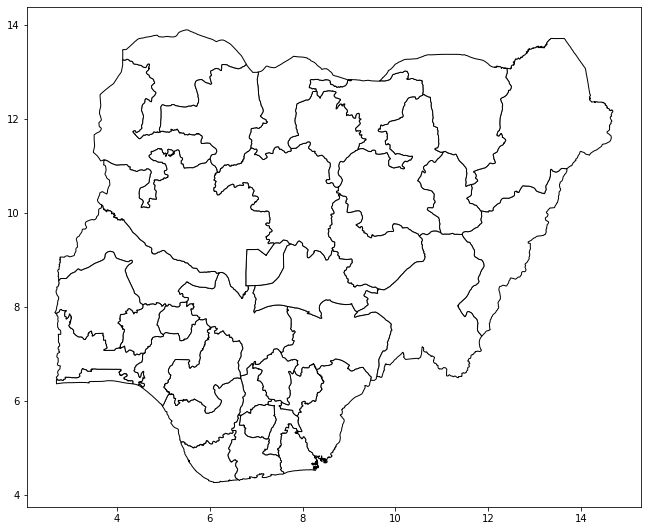

In [48]:

states_file = "./data/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/"

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs = "EPSG:4326"
nigeria = world[(world['name'] == 'Nigeria')]
base = nigeria.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))

layers = fiona.listlayers(states_file)
zones_gdf = gpd.read_file(states_file, layer=1)
zones_gdf.crs = "EPSG:4326"
zones_gdf = zones_gdf.set_index('admin1Name_en')
zones_gdf.plot(ax=base, color='white', edgecolor='black')
plt.show()

/opt/anaconda3/envs/hackathon/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/opt/anaconda3/envs/hackathon/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/hackathon/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

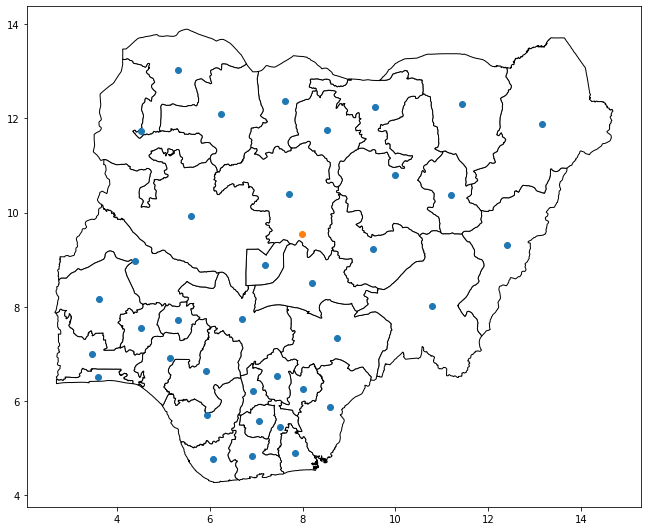

In [49]:
# Plot the centre of each state and teh centre of Nigeria
zones_gdf['centre'] = zones_gdf.centroid
nigeria['centre'] = nigeria['geometry'].centroid

base = nigeria.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))
zones_gdf.plot(ax=base, color='white', edgecolor='black')
zones_gdf['centre'].plot(ax=base)
nigeria['centre'].plot(ax=base)


plt.show()

In [50]:
# Calculate the Polar coordinates of each state using Lagos as the the centre
central_point = zones_gdf.loc['Lagos'].centre
zones_gdf['distance from lagos'] = zones_gdf['centre'].apply(lambda centre: np.sqrt((central_point.x - centre.x)**2 + (central_point.y - centre.y)**2))
zones_gdf['angle from lagos'] = zones_gdf.drop('Lagos')['centre'].apply(lambda centre: np.arctan((central_point.y - centre.y)/(central_point.x - centre.x)))
zones_gdf.loc['Lagos', 'angle from lagos'] = 0

In [51]:
distance_df = zones_gdf[['distance from lagos', 'angle from lagos']]
distance_df.head()

,distance from lagos,angle from lagos
admin1Name_en,,
Abia,4.078825,-0.265213
Adamawa,9.247603,0.307701
Akwa Ibom,4.556499,-0.362497
Anambra,3.358605,-0.089337
Bauchi,7.699042,0.588559


In [52]:
data = data.join(distance_df)
data.head()

,Total Cases,Population,"Cases/100,000",Infant Mortality,Fertility rate,Improved drinking water,Percentge heard of AIDS,Literacy rate,Area,Pop Density,fac_per_100k,distance from lagos,angle from lagos
REGION,,,,,,,,,,,,,
Abia,1134,3644714,31.113552,62.40,6.53,87.85,99.75,94.24,6320,576.695253,6.859249,4.078825,-0.265213
Adamawa,573,4145684,13.821603,36.38,3.28,37.68,85.15,55.82,36917,112.297424,1.592017,9.247603,0.307701
Akwa Ibom,698,5353609,13.037934,59.07,3.88,65.54,98.72,78.84,7081,756.052676,4.744463,4.556499,-0.362497
Anambra,515,5425334,9.492503,28.13,5.34,74.89,98.71,92.11,4844,1120.011148,8.718357,3.358605,-0.089337
Bauchi,1107,6386388,17.333742,85.62,4.05,35.02,88.83,19.26,49119,130.018689,1.080423,7.699042,0.588559


In [53]:

X=data[['Infant Mortality','Fertility rate','Improved drinking water','Percentge heard of AIDS','Literacy rate','Pop Density','fac_per_100k', 'distance from lagos', 'angle from lagos']]
y = data['Cases/100,000']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

linearModel = LinearRegression().fit(X_train, y_train)

lin_preds = linearModel.predict(X_test)

lin_mse = mean_squared_error(y_test, lin_preds)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(y_test, lin_preds)
print(f'Linear regression RMSE {lin_rmse:.2f}')
print(f'Linear regression MAE {lin_mae:.2f}')

svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_preds = svr_model.predict(X_test)

svr_mse = mean_squared_error(y_test, svr_preds)
svr_rmse = np.sqrt(svr_mse)
svr_mae = mean_absolute_error(y_test, svr_preds)
print(f'SVR RMSE {svr_rmse:.2f}')
print(f'SVR MAE {svr_mae:.2f}')

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)

tree_mse = mean_squared_error(y_test, tree_preds)
tree_rmse = np.sqrt(tree_mse)
tree_mae = mean_absolute_error(y_test, tree_preds)
print(f'Tree regression RMSE {tree_rmse:.2f}')
print(f'Tree regression MAE {tree_mae:.2f}')

gbm = lgb.LGBMRegressor(min_data_in_leaf = 1, min_data_in_bin = 1, n_estimators=50, max_depth = 6, num_leaves = 50)
gbm.fit(X_train, y_train)

gbm_preds = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

gbm_mse = mean_squared_error(y_test, gbm_preds)
gbm_rmse = np.sqrt(gbm_mse)
gbm_mae = mean_absolute_error(y_test, gbm_preds)
print(f'GBM regression RMSE {gbm_rmse:.2f}')
print(f'GBM regression MAE {gbm_mae:.2f}')


Linear regression RMSE 149.99
Linear regression MAE 98.08
SVR RMSE 89.97
SVR MAE 39.44
Tree regression RMSE 87.86
Tree regression MAE 42.00
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
GBM regression RMSE 88.80
GBM regression MAE 42.78


In [54]:
print()
print('Feature importance Decision Tree Regressor')
for name, score in zip(X.columns, tree_model.feature_importances_):
    print(name,score)

print()
print('Feature importance Linear Regression')
for name, score in zip(X.columns, np.abs(linearModel.coef_)):
    print(name,score)


Feature importance Decision Tree Regressor
Infant Mortality 0.0037217068249333174
Fertility rate 0.0008237812295306197
Improved drinking water 0.0014828922560553887
Percentge heard of AIDS 0.24140842632253875
Literacy rate 0.0
Pop Density 0.6515236370428186
fac_per_100k 0.04194448200449673
distance from lagos 0.05890623079113389
angle from lagos 0.00018884352849263877

Feature importance Linear Regression
Infant Mortality 20.828705429086973
Fertility rate 13.229216873447312
Improved drinking water 23.513017930085393
Percentge heard of AIDS 29.33106842578473
Literacy rate 67.5751017382014
Pop Density 10.158256801256293
fac_per_100k 42.24300420541236
distance from lagos 14.337741194647847
angle from lagos 38.735479561806294


Comparing the feature importances between the models we can see that the only feature they agree on as being importants is the "Percentage Heard of AIDS". Lets see how that compares to a Random Forest Regressor

Infant Mortality 0.0433740587836266
Fertility rate 0.04934649083654705
Improved drinking water 0.07886710225122567
Percentge heard of AIDS 0.33167521152505036
Literacy rate 0.02369858619285812
Pop Density 0.11023282213656939
fac_per_100k 0.09756263183364533
distance from lagos 0.1131568240071111
angle from lagos 0.1520862724333664
RF regression RMSE 90.41
RF regression MAE 49.31


<AxesSubplot:xlabel='REGION'>

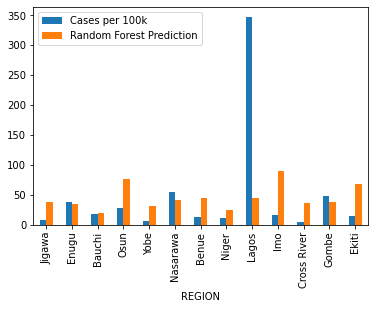

In [56]:
from sklearn.ensemble import RandomForestRegressor 

rnd_forest_model = RandomForestRegressor(n_estimators=500)
rnd_forest_model.fit(X_train, y_train)
for name, score in zip(X.columns, rnd_forest_model.feature_importances_):
    print(name,score)

rf_preds = rnd_forest_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_preds)
print(f'RF regression RMSE {rf_rmse:.2f}')
print(f'RF regression MAE {rf_mae:.2f}')

results_df = pd.DataFrame({'Cases per 100k':y_test, 'Random Forest Prediction': rf_preds})

results_df.plot.bar()



Interestinglt the RF gives different results again but also agrees on the "Percentage Heard of Aids" as being important. 

What is we reduce the feature set to remove some of the noise?

In [61]:
X = data[['Percentge heard of AIDS','fac_per_100k', 'distance from lagos', 'angle from lagos']]
y = data['Cases/100,000']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

linearModel = LinearRegression().fit(X_train, y_train)

lin_preds = linearModel.predict(X_test)

lin_mse = mean_squared_error(y_test, lin_preds)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(y_test, lin_preds)
print(f'Linear regression RMSE {lin_rmse:.2f}')
print(f'Linear regression MAE {lin_mae:.2f}')

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)

tree_mse = mean_squared_error(y_test, tree_preds)
tree_rmse = np.sqrt(tree_mse)
tree_mae = mean_absolute_error(y_test, tree_preds)
print(f'Tree regression RMSE {tree_rmse:.2f}')
print(f'Tree regression MAE {tree_mae:.2f}')

gbm = lgb.LGBMRegressor(min_child_samples = 1, min_data_in_bin = 1, n_estimators=50, max_depth = 6, num_leaves = 50)
gbm.fit(X_train, y_train)

gbm_preds = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

gbm_mse = mean_squared_error(y_test, gbm_preds)
gbm_rmse = np.sqrt(gbm_mse)
gbm_mae = mean_absolute_error(y_test, gbm_preds)
print(f'GBM regression RMSE {gbm_rmse:.2f}')
print(f'GBM regression MAE {gbm_mae:.2f}')

Linear regression RMSE 92.58
Linear regression MAE 63.77
Tree regression RMSE 89.37
Tree regression MAE 47.91
GBM regression RMSE 81.64
GBM regression MAE 40.16


Reducing the feaure set improved the performance a little. The best seems to be the GBM method.



<AxesSubplot:title={'center':'Predicted Cases per 100k vs Actual'}, xlabel='State', ylabel='Cases per 100k'>

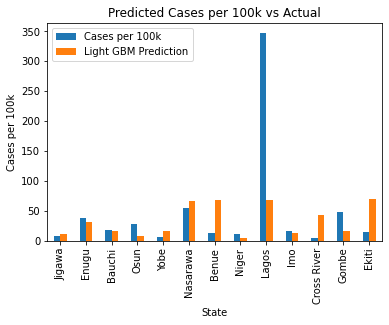

In [66]:
results_df = pd.DataFrame({'Cases per 100k':y_test, 'Light GBM Prediction': gbm_preds})

results_df.plot.bar(title='Predicted Cases per 100k vs Actual', xlabel='State', ylabel='Cases per 100k')


What if we tried stacking the models together?

[69.10156208795948, 162.78297566264197, 118.3211151643099, 35.715275533834514, 48.38357418425244]
[ 29.30417846 165.82013565 127.22443595  16.88293972  21.68755047]
[ 31.93782718 204.95963035 136.28581223  21.73855807  28.87507925]
[ 29.79886268 175.44123433 134.96954277  20.45412545  24.37673449]
[ 43.95774669 167.82228664 131.38928349  55.93624064  37.61530258]
86.86090052659966 72.18384805210543 84.75938141735031 87.34417200785165


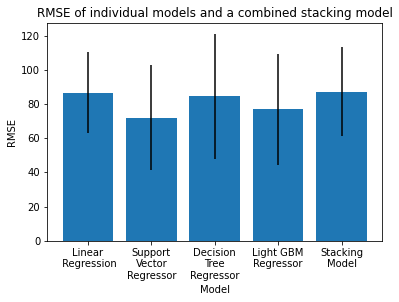

In [84]:
cv = KFold(n_splits=5, shuffle=True, random_state=25)
scores_linreg = []
for train_index, test_index in cv.split(X):
    x_train, x_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model_linreg = LinearRegression().fit(x_train, y_train)
    
    error = np.sqrt(mean_squared_error(model_linreg.predict(x_test),y_test))
    scores_linreg += [error]
print(scores_linreg)

model_svr = SVR(kernel='linear')
scores_svr = np.sqrt(-cross_val_score(model_svr, X, y, scoring='neg_mean_squared_error', cv=cv))
print(scores_svr)

model_dtr = DecisionTreeRegressor()
scores_dtr = np.sqrt(-cross_val_score(model_dtr, X, y, scoring='neg_mean_squared_error', cv=cv))
print(scores_dtr)

model_lgb = lgb.LGBMRegressor(min_child_samples = 1, min_data_in_bin = 1, n_estimators=50, max_depth = 6, num_leaves = 50)
scores_lgb = np.sqrt(-cross_val_score(model_lgb, X, y, scoring='neg_mean_squared_error', cv=cv))
print(scores_lgb)


stack_linreg = LinearRegression()
model_stack = StackingRegressor([("linreg", LinearRegression()), ("svc", SVR()), ("dtr", DecisionTreeRegressor()),  ("lgb", lgb.LGBMRegressor(min_child_samples = 1, min_data_in_bin = 1, n_estimators=50, max_depth = 6, num_leaves = 50))], 
                                 final_estimator=stack_linreg, cv=6)
scores_stack = np.sqrt(-cross_val_score(model_stack, X, y, scoring='neg_mean_squared_error', cv=cv))
print(scores_stack)


print(np.mean(scores_linreg), np.mean(scores_svr), np.mean(scores_dtr), np.mean(scores_stack))

scores = np.array([scores_linreg, scores_svr, scores_dtr, scores_lgb, scores_stack])
labels = ["Linear\n Regression", "Support\nVector\nRegressor", "Decision\nTree\nRegressor","Light GBM\nRegressor", "Stacking\nModel"]

sem(scores.T)

plt.bar(range(5), scores.mean(axis=1), yerr=sem(scores.T))
plt.xticks(range(5), labels)
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.title('RMSE of individual models and a combined stacking model')
plt.show()